In [ ]:
!pip install transformers --quiet
!pip install lightning --quiet
!pip install torchmetrics --quiet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import lightning as L
import lightning.pytorch as pl
import torchmetrics as tm
from torch.utils.data import DataLoader,Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.utilities.model_summary import ModelSummary
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.profilers import SimpleProfiler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score


In [ ]:
import os
import shutil
import requests
import zipfile
import time

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import re

from collections import Counter
from tqdm import tqdm

tqdm.pandas()

In [ ]:
log_check = True
model_names = ["lstm","bert","roberta","custom"]
model_set = 1
def log_print(prt):
  if log_check == True:
    print(prt)

In [ ]:
# pytorch device
works = os.cpu_count()
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
  works = torch.cuda.device_count()

print("workers = ",works)
print("device = ",device)

workers =  1
device =  cuda


In [ ]:
root_dir = "/content"
data_dir = "/content/trip-advisior"
zip_dir = "/content/tripadvisor.zip"
csv_dir = "/content/New_Delhi_reviews.csv"

# Google Drive
data_url = "https://drive.google.com/uc?export=download&id=1n-8PTNf24lZJDgZeFN-iBQlwpVQpyPg1&confirm=t"

In [ ]:
# 파일 다운로드
def download(url,file_name):
  if os.path.exists(zip_dir):
    return
  with open(file_name,"wb") as file:
    response = requests.get(url)
    file.write(response.content)
  return os.path.abspath(file_name)

# remove dir
def remove_dir(dir_path):
  if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
    print(f"remove dir : {dir_path}\n")
  os.mkdir(dir_path)

# 압축 해제
def extract(file_path,save_path):
  with zipfile.ZipFile(file_path,"r") as file:
    file.extractall(save_path)
    print(f"save dir : {file_path}\n")

In [ ]:
download(data_url,"tripadvisor.zip")
extract(zip_dir,root_dir)

# tensorboard log 삭제
remove_dirs = [data_dir,"./tb_logs","./logs"]
for r in remove_dirs:
  remove_dir(r)

save dir : /content/tripadvisor.zip

remove dir : /content/trip-advisior

remove dir : ./tb_logs

remove dir : ./logs



In [ ]:
seed = 192804324

input_col = "input"
columns = ["y",input_col]
d_type = {"y":'int8',input_col:"string"}
test_size, val_size = 0.2,0.2
test_size += val_size
val_size = val_size/test_size

In [ ]:
# read_csv
def csv_to_dataset(csv_path,column_name,d_type):
  return pd.read_csv(csv_path, names=column_name, header=0, dtype=d_type)

# seed 고정
def random_seed(seed):
  torch.manual_seed(seed)

# 데이터 셋 split
def dataset_split(dataframe):
  train_set , test_set = train_test_split(dataframe,test_size=test_size,random_state=seed,stratify=dataframe["y"])
  test_set, val_set = train_test_split(test_set,test_size=val_size,random_state=seed,stratify=test_set["y"])
  return train_set,val_set,test_set

In [ ]:
# progress bar
def tqdm_bar(iter,desc = None):
  return tqdm(iter,
              desc = desc,
              ncols = 100,
              leave = True)

# 히스토그램
def histogram(dataframe, label, bins=100):
  plt.hist(dataframe, bins=bins, label=label)
  plt.legend()
  plt.show()
  plt.savefig(f"{label}.png")

def cplot(dataframe,label):
  sns.countplot(x=dataframe)

In [ ]:
# csv to dataframe
data_df = csv_to_dataset(csv_dir,columns,d_type)
# 결측값 제거 (문장 이외의 input이 없음)
data_df.dropna(inplace=True)
log_print(data_df.head(3))

log_print(f"\n<<< dtypes >>>\n{data_df.dtypes}\n")

# input의 길이
data_len = data_df[input_col].apply(lambda x:len(x))
# label encode
labeling = [0,0,1,2,3,4]
data_df["y"] = data_df["y"].apply(lambda x:labeling[x])
log_print(("data_len_des : ", data_len.describe()))

log_print(f"\nshape : {data_df.shape}")
log_print(f"\ninfo : {data_df.head(2)}")


   y                                              input
0  5  Totally in love with the Auro of the place, re...
1  5  I went this bar 8 days regularly with my husba...
2  5  We were few friends and was a birthday celebra...

<<< dtypes >>>
y          int8
input    string
dtype: object

('data_len_des : ', count    147579.000000
mean        404.745445
std         463.877369
min           6.000000
25%         163.000000
50%         263.000000
75%         462.000000
max        8192.000000
Name: input, dtype: float64)

shape : (147579, 2)

info :    y                                              input
0  4  Totally in love with the Auro of the place, re...
1  4  I went this bar 8 days regularly with my husba...


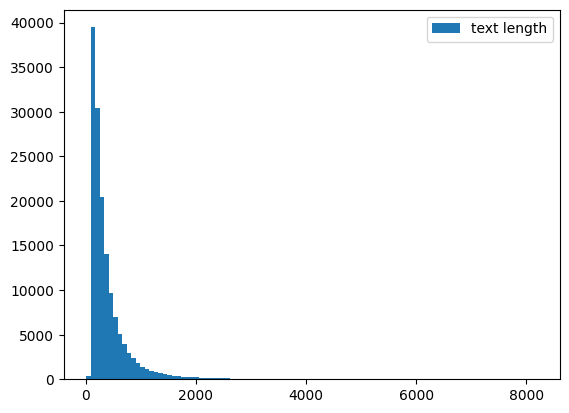

<Figure size 640x480 with 0 Axes>

In [ ]:
# 문장의 길이 histogram 출력
histogram(data_len, "text length")

4    0.490510
3    0.340482
2    0.107976
1    0.030844
0    0.030187
Name: y, dtype: float64


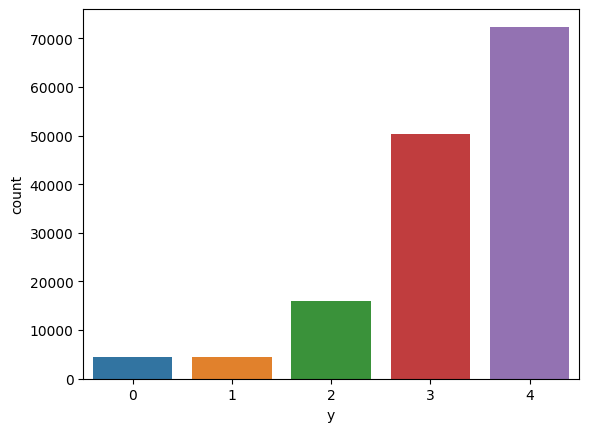

In [ ]:
# label 별 개수,비율 출력
cplot(data_df["y"],"label")
log_print(data_df["y"].value_counts(normalize=True))

# 클래스 불균형함
# label이 4인 샘플들이 gradient에 큰 영향을 줌

In [ ]:
# 클래스별 데이터 수
class_num = data_df["y"].value_counts(sort=False).values
log_print(class_num)

# 클래스별 가중치
class_weight = class_num/sum(class_num)
print(class_weight)


[72389 50248 15935  4455  4552]
[0.49051017 0.34048205 0.10797607 0.03018722 0.0308445 ]


In [ ]:
import transformers

from transformers import BertConfig, BertTokenizer, BertForSequenceClassification ,BertModel
from transformers import RobertaConfig, RobertaTokenizer, RobertaForSequenceClassification
from tokenizers import BertWordPieceTokenizer

In [ ]:
import nltk

from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, pos_tag , FreqDist
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.tokenize import word_tokenize
from nltk import ngrams

# 불용어
nltk.download("stopwords")
# Word Tokenize
nltk.download("punkt")
# 품사 태깅
nltk.download('averaged_perceptron_tagger')
# Wordnet
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import gensim
import gensim.downloader
from gensim.models import Word2Vec
from gensim.test.utils import common_texts

In [ ]:
# 전처리 테스트용 데이터
test_samples = 15000
mini_data = data_df.sample(test_samples,random_state=seed).copy()
use_data = data_df

log_print(f"\n{mini_data}")


        y                                              input
69257   2  Went to thia Belgian fries restaurant after lo...
94138   3  Being an ardent foodie I love visiting new foo...
33311   3  We ate at Lazeez Affaire twice during our time...
17668   4  Had a brunch meet at welcom hotel , dwarka . H...
110578  4  Nandkishor amazing help to every meal we have ...
...    ..                                                ...
70517   4  Brilliant place enjoyed myself immensely, grea...
136297  3  You will get one of the best Biryani of the co...
79196   4  Small place with only a few tables and was alw...
25359   4  This is a vegetarian's paradise in CP. Their m...
126679  4  One of the oldest and original cuisine makers....

[15000 rows x 2 columns]


In [ ]:
# Tokenize / str -> list
class WordTokenize:
  def __init__(self):
    pass

  def __call__(self,dataframe):
    dataframe["input_ids"] = dataframe[input_col].progress_apply(self.word_tokenize)
    dataframe.drop([input_col],axis=1,inplace=True)
    return dataframe

  def word_tokenize(self,text):
    return word_tokenize(text)

  def ids_to_tokens(self,seq):
    return seq


In [ ]:
# 정규식으로 특수 문자 제거
class Regex:
  def __init__(self):
    pass

  def __call__(self,dataframe):
    start_time = time.perf_counter()
    dataframe[input_col] = dataframe[input_col].progress_apply(self.remove_spec_char)
    log_print(f"Regex time : {time.perf_counter() - start_time}")
    return dataframe

  def remove_spec_char(self,text):
    spec = re.compile(r"[^a-zA-Z ]+")
    space = re.compile(r"  ")
    text = spec.sub(" ",str(text))
    return space.sub(" ",str(text))

In [ ]:
# 해당 데이터 셋으로 bert tokenize
class BertCustom:
  def __init__(self,max_pad,pad="max_length",lower=True):
    self.BertWPtokenizer = BertWordPieceTokenizer(
        lowercase = lower,
        wordpieces_prefix = "##"
    )
    self.tokenizer = None
    self.max_pad = max_pad
    self.pad = pad
    self.vocab_dir = os.path.join(data_dir,"vocab")
    self.tokenizer_path = os.path.join(self.vocab_dir,"tokenizer.json")
    self.txt_path = os.path.join(self.vocab_dir,"vocab.txt")
    self.vocab_size = 10000
    self.limit_alphabet = 6000
    self.min_frequency = 5
    self.special_tokens = ["[PAD]","[UNK]","[CLS]","[SEP]","[MASK]"]
    self.user_defined_symbols = ["[BOS]","[EOS]"]
    self.unused_tokens = [f"[unused{i}]" for i in range(200)]
    self.spec_tokens = self.special_tokens+self.user_defined_symbols+self.unused_tokens

  def __call__(self,dataframe):
    self.make_dir()
    self.make_pretrained(dataframe)
    self.load_pretrained()
    return self.get_sequence(dataframe)

  # custom pretrained
  def make_pretrained(self,dataframe):
    text_series = dataframe[input_col]
    self.train_iterator(text_series)
    self.BertWPtokenizer.save(self.tokenizer_path)
    self.vocab_txt()

  def load_pretrained(self):
    self.tokenizer = BertTokenizer.from_pretrained(self.vocab_dir)

  def make_dir(self):
    if not os.path.exists(self.vocab_dir):
      os.mkdir(self.vocab_dir)

  # train from iterator
  def train_iterator(self,dataframe):
    self.BertWPtokenizer.train_from_iterator(
        dataframe,
        vocab_size=self.vocab_size,
        limit_alphabet=self.limit_alphabet,
        special_tokens=self.spec_tokens,
        min_frequency=self.min_frequency,
        show_progress=True
    )

  # vocab txt 파일
  def vocab_txt(self):
    with open(self.txt_path,"wb") as v_file:
      with open(self.tokenizer_path,"r") as t_file:
        json_data = json.load(t_file)
        for k in json_data['model']['vocab'].keys():
          v_file.write(f"{k}\n".encode("utf-8"))

  def encode(self,texts):
    encoded = self.tokenizer(
        texts,truncation=True,
        padding=self.pad,
        max_length=self.max_pad,
        return_attention_mask=True,
        return_token_type_ids=False
    )
    return encoded["input_ids"],encoded["attention_mask"]

  def get_sequence(self,dataframe):
    start = time.perf_counter()
    df2list = dataframe[input_col].tolist()
    dataframe["input_ids"],dataframe["attention_mask"] = self.encode(df2list)
    dataframe.drop([input_col],aixs=1,inplace=True)
    print(("perf time : ",time.perf_counter()-start))
    return dataframe

In [ ]:
# 토큰화용 Vocab 생성 / sentence -> list
# Bert tokenize
class BertTokenize:
  def __init__(self,max_pad,pad="max_length"):
    self.max_pad = max_pad
    self.pad = pad
    self.tokenizer = None

  def __call__(self,dataframe):
    self.set_pretrained("bert-base-uncased")
    return self.get_ids(dataframe)

  def set_pretrained(self,model_name):
    self.tokenizer = BertTokenizer.from_pretrained(model_name)

  # encode
  def encode(self,texts):
    encoded = self.tokenizer(
        texts,truncation=True,
          padding=self.pad,
          max_length=self.max_pad,
          return_attention_mask=True,
          return_token_type_ids=False
    )
    return encoded["input_ids"],encoded["attention_mask"]

  def ids_to_tokens(self,ids):
    tokens = self.tokenizer.convert_ids_to_tokens(ids)
    return tokens

  # encode
  def get_ids(self,dataframe):
    start_time = time.perf_counter()
    df2list = dataframe[input_col].tolist()
    dataframe["input_ids"],dataframe["attention_mask"] = self.encode(df2list)
    dataframe.drop([input_col],axis = 1,inplace=True)
    log_print(f"tokenize time : {time.perf_counter()-start_time}")

    return dataframe

In [ ]:
# Robert Tokenize
class RobertaTokenize:
  def __init__(self,max_pad,pad="max_length"):
    self.tokenizer = None
    self.max_pad = max_pad
    self.pad = pad

  def __call__(self,dataframe):
    self.set_pretrained()
    self.get_ids(dataframe)
    return dataframe

  def set_pretrained(self):
    self.tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

  def encode(self,texts):
    encoded = self.tokenizer(
        texts,truncation = True,
          padding = self.pad,
          max_length = self.max_pad,
          return_attention_mask = True,
          return_token_type_ids = False
    )
    return encoded["input_ids"],encoded["attention_mask"]

  def ids_to_tokens(self,ids):
    tokens = self.tokenizer.convert_ids_to_tokens(ids)
    return tokens

  def get_ids(self,dataframe):
    start_time = time.perf_counter()
    df2list = dataframe[input_col].tolist()
    dataframe["input_ids"],dataframe["attention_mask"] = self.encode(df2list)
    dataframe.drop([input_col],axis=1,inplace=True)
    print(("tokenize time : ",time.perf_counter()-start_time))

    return dataframe

In [ ]:
# 불용어 제거 / list -> list
class Stopword():
  def __init__(self):
    # in 연산자 성능을 위해 set으로 변환
    self.stopwords = set(stopwords.words("english"))

  def __call__(self,dataframe):
    start_time = time.perf_counter()
    dataframe[input_col] = dataframe[input_col].progress_apply(self.del_stopwords)
    log_print(f"stopword time : {time.perf_counter() - start_time}")
    return dataframe

  def del_stopwords(self,texts):
    texts = texts.split(" ")
    new_texts = [t for t in texts if t not in self.stopwords]
    return " ".join(new_texts)

In [ ]:
# 정규화 (어간 or 표제어 추출) / list -> list
class Normalize():
  def __init__(self):
    pass

  def __call__(self,dataframe):
    df_list = dataframe[input_col].tolist()
    for i,d in enumerate(df_list):
      df_list[i] = self.wordnet_lem(d)
    dataframe[input_col] = df_list
    return dataframe

  # 품사 태그 (text list -> text list)
  def pos_tag(self,texts):
    wn = {"V":"v", "N":"n", "J":"a", "R":"r"}
    new_texts = []
    for i,tu in enumerate(pos_tag(texts)):
      # 첫번째 문자로 품사 분류
      str_start = tu[1][0]
      if str_start in wn.keys():
        new_texts.append((tu[0],wn[str_start]))
      else:
        new_texts.append(tu[0])
    return new_texts

  # 어간 추출
  def lancaster_stem(self,texts):
    lancaster = LancasterStemmer()
    for i in range(len(texts)):
      texts[i] = lancaster.stem(texts[i])
    return texts

  # 표제어 추출 (list -> list)
  def wordnet_lem(self,texts):
    wordnet = WordNetLemmatizer()
    texts = texts.split(" ")
    texts = self.pos_tag(texts)
    return " ".join([wordnet.lemmatize(t[0],t[1]) if type(t) == tuple else wordnet.lemmatize(t) for t in texts])

In [ ]:
# 패딩 list -> list
class Padding():
  def __init__(self,max_len):
    self.max_len = max_len

  def __call__(self,dataframe):
    dataframe["input_ids"] = dataframe["input_ids"].apply(self.pad)
    return dataframe

  def pad(self,texts):
    padd = []
    for i in range(self.max_len):
      if i < len(texts):
        padd.append(texts[i])
      else:
        padd.insert(0,"")
    return padd

In [ ]:
# 임베딩 list -> list
class Embedding():
  def __init__(self,emb_size):
    self.model = None
    self.emb_size = emb_size

  def __call__(self,dataframe):
    self.GloVe_pretrained()
    dataframe["input_ids"] = dataframe["input_ids"].progress_apply(self.word_embedding)

    return dataframe

  def train_word2vec(self,dataframe,epochs):
    model = Word2Vec(sentences = common_texts,
                        vector_size = max_len,
                        window = 2,
                        workers = works)

    model.init_sims(replace = True)
    model.train(dataframe ,total_samples=1, epochs=epochs)
    self.model = model

  def GloVe_pretrained(self):
    self.model = gensim.downloader.load(f"glove-twitter-{self.emb_size}")
    log_print(f'\n {self.model["cat"]}')

  def word_embedding(self,texts):
    return [self.model[t] if t in self.model else [0 for _ in range(self.emb_size)] for t in texts]

In [ ]:
# 전처리 수행
class Preprocess():
  def __init__(self,dataframe,pre_classes):
    self.Pre_classes = pre_classes
    self.dataframe = dataframe

  def __call__(self):
    log_print(f"<<Before>>\n{self.dataframe.head(2)}")
    for p in self.Pre_classes:
      log_print(f" == {p} ==")
      self.dataframe = p(self.dataframe)
      display(self.dataframe.head(2))

    return self.dataframe

  def get_df(self):
    return self.dataframe

In [ ]:
def token_seq_len(dataframe,pre_class,token_name,bin=50):
  preprocess = Preprocess(dataframe,pre_class)
  prc_data = preprocess()
  data_len = prc_data["input_ids"].apply(lambda x:len(x))
  log_print(f"== length ==\n{data_len.head(3)}")
  histogram(data_len,f"{token_name} seq length",bins=bin)
  return prc_data

<<Before>>
   y                                              input
0  4  Totally in love with the Auro of the place, re...
1  4  I went this bar 8 days regularly with my husba...
 == <__main__.Regex object at 0x7de6889bf910> ==


100%|██████████| 147579/147579 [00:06<00:00, 22540.39it/s]

Regex time : 6.583114050999939


,y,input
0,4,Totally in love with the Auro of the place rea...
1,4,I went this bar days regularly with my husban...


 == <__main__.Stopword object at 0x7de6889bdde0> ==


100%|██████████| 147579/147579 [00:05<00:00, 27217.60it/s]

stopword time : 5.450120202000107


,y,input
0,4,Totally love Auro place really beautiful quite...
1,4,I went bar days regularly husband fully satis...


 == <__main__.BertTokenize object at 0x7de6889bfd60> ==
tokenize time : 219.853622996


,y,input_ids,attention_mask
0,4,"[101, 6135, 2293, 8740, 3217, 2173, 2428, 3376...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,4,"[101, 1045, 2253, 3347, 2420, 5570, 3129, 3929...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


== length ==
0    97
1    25
2    18
Name: input_ids, dtype: int64


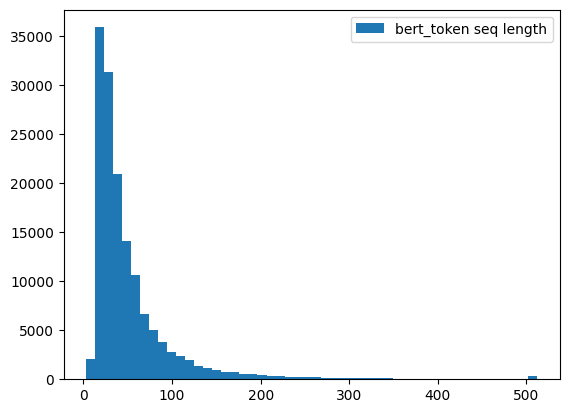

<Figure size 640x480 with 0 Axes>

In [ ]:
# tokenize seq length check
test_data = use_data.copy()
# 공통으로 수행할 전처리
pre_class = [
    Regex(),
    Stopword()]

model_pre = [[WordTokenize()],
             [BertTokenize(max_pad=None,pad=False)],
             [RobertaTokenize(max_pad=None,pad=False)],
             [BertCustom(max_pad=None,pad=False)]]
t_names = ["word_token",
           "bert_token",
           "roberta_token",
           "custom_token"]
max_len = [128,
           128,
           128,
           128]

pre_class.extend(model_pre[model_set])
test_data = token_seq_len(test_data,pre_class,t_names[model_set])

In [ ]:
# n개의 연결된 토큰의 label 일관성 확인
class WordCounter():
  def __init__(self,n):
    self.n = n
    self.labels = None
    self.tokens = list()
    self.seq_token = list()
    self.columns = [f"seq{i}" for i in range(self.n)]
    self.columns.append("label")

  def __call__(self,df_ids,df_label):
    start_time = time.perf_counter()
    self.id2tokens(df_ids,df_label)
    log_print(f"id_to_token time : {time.perf_counter() - start_time}")
    self.ngram_counts()
    return pd.DataFrame(self.seq_token,columns=self.columns)

  # token ids to tokens
  def id2tokens(self,df_ids,df_label):
    ids = df_ids.to_list()
    self.labels = df_label.to_list()
    for i in ids:
      self.tokens.append(model_pre[model_set][0].ids_to_tokens(i))

  # token을 n개씩 묶어 label별 count
  def ngram_counts(self):
    for tk,label in zip(tqdm_bar(self.tokens),self.labels):
      n_tk = [tk[i:] for i in range(self.n)]
      labels = [label for i in range(len(tk)-self.n+1)]
      self.seq_token.extend(list(zip(*n_tk,labels)))

def entropy(counts):
  sum_c = sum(counts)
  return 1 - sum([(c/sum_c)**2 for c in counts])

def ratio(counts):
  labels = counts[:,0]
  print(labels)
  sum_c = sum(counts[:,1])
  return [[l,(c/sum_c)] for l,c in counts]

In [ ]:
# 해당 조합의 entropy 측정
n_count = 2
wd_counter = WordCounter(n_count)

seq_df = wd_counter(test_data["input_ids"],test_data["y"])
seq_df = pd.DataFrame(seq_df.value_counts(sort=True),columns=["counts"])
seq_df.reset_index(inplace=True)

columns = seq_df.columns
df_group = seq_df.groupby([columns[c] for c in range(n_count)])
max_counts = df_group.sum().sort_values(["counts"],ascending=False)[["counts"]]
display(max_counts.head(7))

find_word = ("##bie","##nce")
if find_word in seq_df[["seq0","seq1"]].values:
  word_group = df_group.get_group(find_word)["counts"].tolist()
  display("entropy : ",entropy(word_group))

  find_words = seq_df[(seq_df["seq0"] == find_word[0])&(seq_df["seq1"] == find_word[1])]
  label_ratio = ratio(find_words[["label","counts"]].values)
  display("ratio : ",label_ratio)

id_to_token time : 9.336979057000008


100%|████████████████████████████████████████████████████| 147579/147579 [00:01<00:00, 87595.38it/s]


counts
seq0  seq1         
##bie ##nce   23053
am    ##bie   23044
ve    ##g     16315
the   food    16290
[CLS] i       15515
      the     12399
ta    ##sty   12397

'entropy : '

0.6099193071189233

[4 3 2 1 0]


'ratio : '

[[4, 0.5024074957706155],
 [3, 0.35379343252505097],
 [2, 0.10874940354834511],
 [1, 0.022860365245304298],
 [0, 0.012189302910684076]]

In [ ]:
# 전처리
embed = 25

pre_classes = [
    [Regex(),
     Normalize(),
     Stopword(),
     WordTokenize(),
     Padding(max_len[0]),
     Embedding(emb_size=embed)],
    [Regex(),
     Stopword(),
     BertTokenize(max_pad=max_len[1])],
    [Regex(),
     Stopword(),
     RobertaTokenize(max_pad=max_len[2])],
    [Regex(),
     Stopword(),
     BertCustom(max_pad=max_len[3])]
]

preprocess = Preprocess(use_data,pre_classes[model_set])
use_data = preprocess()

<<Before>>
   y                                              input
0  4  Totally in love with the Auro of the place, re...
1  4  I went this bar 8 days regularly with my husba...
 == <__main__.Regex object at 0x7de6cb7ed660> ==


100%|██████████| 147579/147579 [00:02<00:00, 60819.72it/s]

Regex time : 2.4483929749999334


,y,input
0,4,Totally in love with the Auro of the place rea...
1,4,I went this bar days regularly with my husban...


 == <__main__.Stopword object at 0x7de6cb7ecd90> ==


100%|██████████| 147579/147579 [00:02<00:00, 69402.82it/s]

stopword time : 2.138316756000222


,y,input
0,4,Totally love Auro place really beautiful quite...
1,4,I went bar days regularly husband fully satis...


 == <__main__.BertTokenize object at 0x7de6cb7ed210> ==
tokenize time : 203.10363817799998


,y,input_ids,attention_mask
0,4,"[101, 6135, 2293, 8740, 3217, 2173, 2428, 3376...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,4,"[101, 1045, 2253, 3347, 2420, 5570, 3129, 3929...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
# Dataset
class CustomDataset(Dataset):
  def __init__(self,dataframe):
    self.dataframe = dataframe
    self.attention_mask = False
    if "attention_mask" in dataframe.columns:
      self.attention_mask = True
    self.dataframe["input_ids"] = self.dataframe["input_ids"].apply(lambda x : np.array(x,dtype=np.float32))

  def __getitem__(self,index):
    row = self.dataframe.iloc[index]
    if model_set == 0:
      features = torch.Tensor(row["input_ids"])
    else: # input으로 long tensor 받는 모델
      features = torch.LongTensor(row["input_ids"])
    label = torch.tensor(row["y"])
    outputs = {"input_ids":features,"label":label}
    if not self.attention_mask:
      return outputs
    attention_mask = torch.tensor(row["attention_mask"])
    outputs["attention_mask"] = attention_mask
    return outputs

  def __len__(self):
    return len(self.dataframe)

In [ ]:
model_lr = [2e-5,1e-5,2e-5,2e-5]
learning_rate = model_lr[model_set] # bert 학습시 learning rate가 높으면 사전 훈련 지식이 사라짐
model_batch = [64,64,32,64]
batch_size = model_batch[model_set] if device == "cuda" else model_batch[model_set]//2
classes = data_df["y"].nunique()
log_print(batch_size)
log_print(classes)

64
5


In [ ]:
def df2dl(dataframe,shuf=True,sampler=None):
  ds = CustomDataset(dataframe)
  return DataLoader(ds,batch_size=batch_size,shuffle=shuf,sampler=sampler,
                    num_workers=works*2,pin_memory=True)

In [ ]:
# data split
train_df,val_df,test_df = dataset_split(use_data)
log_print(train_df.shape)
log_print(val_df.shape)
log_print(test_df.shape)


(88547, 3)
(29516, 3)
(29516, 3)


In [ ]:
def make_weights(labels):
  print(class_weight)
  sample_weights = []
  for i in labels:
    sample_weights.append(class_weight[i])
  print(sample_weights)
  return sample_weights

In [ ]:
# sampler

In [ ]:
# data loader
train_loader = df2dl(train_df,shuf=False)
val_loader = df2dl(val_df,shuf=False)
test_loader = df2dl(test_df,shuf=False)

# LSTM outputs
# 2(logits,labels) 32(batch) 100(vocab) 25(embed)

In [ ]:
# Model
class LSTM_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden_size = 128
    self.num_layers = 2
    # self.embedding = nn.Embedding(self.hidden_size,embed)
    self.LSTM = nn.LSTM(embed,self.hidden_size,self.num_layers,batch_first=True)
    self.model = nn.Sequential(
        nn.Linear(self.hidden_size,classes),
        nn.Softmax(dim=1)
    )
  def forward(self,batch):
    x = batch["input_ids"]
    x,_ = self.LSTM(x)
    x = x[:,-1]
    outputs = self.model(x)
    return outputs

class BERTClassificationModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.pretrain = "bert-base-uncased"
    Config = BertConfig.from_pretrained(self.pretrain)
    Config.num_labels = classes
    Config.classifier_dropout=0.4
    self.model = BertForSequenceClassification.from_pretrained(self.pretrain,config = Config)

  def forward(self,batch):
    x,a = batch["input_ids"],batch["attention_mask"]
    y = None
    if "label" in batch:
      y = batch["label"]
    outputs = self.model(input_ids=x,attention_mask=a,labels=y)
    loss,logits = outputs[:2]
    return loss,logits

class BERTModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.pretrain = "bert-base-uncased"
    self.hidden_size = 768 #default
    Config = BertConfig.from_pretrained(self.pretrain)
    Config.hidden_size = self.hidden_size
    self.model = BertModel.from_pretrained(self.pretrain,config=Config)
    self.fc_layers = nn.Linear(self.hidden_size,classes)
    self.dropout = nn.Dropout(0.4)
    self.softmax = nn.Softmax(dim=1)

  def forward(self,batch):
    x,a = batch["input_ids"],batch["attention_mask"]
    x = self.model(input_ids=x,attention_mask=a,output_hidden_states=True)
    x = self.dropout(x[1])
    # pooler output (분류용 cls 토큰 hidden_state)
    x = self.fc_layers(x)
    logits = self.softmax(x)
    return logits

class RoBERTaModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.pretrain = "roberta-base"
    Config = RobertaConfig.from_pretrained(self.pretrain)
    Config.num_labels = classes
    Config.classifier_dropout = 0.4
    self.model = RobertaForSequenceClassification.from_pretrained(self.pretrain,config = Config)

  def forward(self,batch):
    x,a = batch["input_ids"],batch["attention_mask"]
    y = None
    if "label" in batch:
      y = batch["label"]
    outputs = self.model(input_ids=x,attention_mask=a,labels=y)
    logits = outputs[1]
    return logits

In [ ]:
# log_print(BERTClassificationModel())

In [ ]:
# log_print(BERTModel())

In [ ]:
# 장치 전체의 메트릭 감소 (?)
sync_dist_on = False

In [ ]:
class Pl_train(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.accuracy = tm.Accuracy(task="multiclass",num_classes=classes)
    self.val_step_outputs = []
    self.model = None
    if model_set == 0:
      self.model = LSTM_model()
    elif model_set == 1:
      # self.model = BERTClassificationModel()
      self.model = BERTModel()
    elif model_set == 2:
      self.model = RoBERTaModel()
    elif model_set == 3:
      self.model = BERTModel()

    self.alpha = 1
    self.gamma = 3

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.model.parameters(),lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer,factor = 0.5,patience = 3,
                                  min_lr = 1e-6,verbose=True)
    return {"optimizer":optimizer,
            "lr_scheduler":scheduler,
            "monitor":"val_loss"}

  def focal_loss(self,y,logits):
    ce_loss = F.cross_entropy(logits,y,reduction="none")
    # logits == exp(log(logits))
    pt = torch.exp(-ce_loss)
    F_loss = self.alpha*(1-pt)**self.gamma*ce_loss
    return F_loss.mean()

  def loss(self,y,logits):
    CE = nn.CrossEntropyLoss()
    return CE(logits,y)

  def forward(self,batch):
    logits = self.model(batch)
    return logits

  def step(self,batch,batch_idx):
    y=batch["label"]
    # loss,logits = self.model(batch)
    logits = self.model(batch)
    loss = self.focal_loss(y,logits)
    # loss = self.loss(y,logits)
    acc = self.accuracy(logits,y)
    return loss,acc

  def training_step(self,batch,batch_idx):
    loss,acc = self.step(batch,batch_idx)
    metrics = {"train_acc":acc,"train_loss":loss}
    self.log_dict(metrics,sync_dist=sync_dist_on,prog_bar=True,
                  on_epoch=True,on_step=False)
    return loss

  def validation_step(self,batch,batch_idx):
    loss,acc = self.step(batch,batch_idx)
    metrics = {"val_acc":acc,"val_loss":loss}
    self.val_step_outputs.append(loss)
    self.log_dict(metrics,sync_dist=sync_dist_on,prog_bar=True,
                  on_epoch=True,on_step=False)

  def test_step(self,batch,batch_idx):
    loss,acc = self.step(batch,batch_idx)
    metrics = {"test_acc":acc,"test_loss":loss}
    self.log_dict(metrics,sync_dist=sync_dist_on,prog_bar=True,
                  on_epoch=True,on_step=False)

  def on_validation_epoch_end(self):
    avg_loss = torch.stack(self.val_step_outputs).mean()
    self.log("val_loss_avg",avg_loss)
    self.val_step_outputs.clear()

  def predict_step(self,batch,batch_idx,dataloader_idx=0):
    logits = self.model(batch)
    return logits

In [ ]:
epochs = 20
log_dir = "logs"
model_name = "Model"
tv_logger = TensorBoardLogger("tb_logs",name = model_name,version=0)
smp_profiler = SimpleProfiler()

# callbacks
early_stop = EarlyStopping(monitor = "val_loss",patience = 5)
callback = [early_stop]

In [ ]:
# trainer 생성
def set_trainer(workers = works,num_nodes=1,callbacks=None,root_dir=None,logger=None):
  return pl.Trainer(
      accelerator=device,
      max_epochs=epochs,
      devices="auto",
      logger=logger,
      num_nodes=num_nodes,
      callbacks=callbacks,
      log_every_n_steps=4,
      default_root_dir=root_dir,
      accumulate_grad_batches=1,   # 몇개의 배치만큼 gradients를 누적 할지
      precision="16-mixed", # 16bit precision (default = 32)
      profiler=None
      )

# 파라미터 확인
def get_parameters(parameters,index):
  for i,(name,param) in enumerate(parameters):
    if i == index:
      print("param_size : ",param.size())
      print(f"{name} : {param}")

In [ ]:
# log_dir = f"/contents/{log_dir}/{model_name}/version_{pl_logger.version}"
model = Pl_train()
trainer = set_trainer(logger=tv_logger)

# log_print(ModelSummary(model,max_depth=-1))

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# %load_ext tensorboard
# log_dir = "./tb_logs"

# %tensorboard --logdir {log_dir}

In [ ]:
def parameter(model_):
  model_len = len(model.state_dict())-1
  print(model_len)
  check_idx = set(range(model_len-2,model_len))
  if log_check == True:
    for i,(named,param) in enumerate(model_.named_parameters()):
        if i in check_idx:
          print(f"named : {named}\n{param.shape}\n{param}")

In [ ]:
# parameter(model)

In [ ]:
# torch.cuda.empty_cache()
# get_parameters(model.named_parameters(),0)
trainer.fit(model,train_dataloaders=train_loader,val_dataloaders=val_loader)
# get_parameters(model.named_parameters(),0)
trainer.test(model,dataloaders=test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params
------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0     
1 | model    | BERTModel          | 109 M 
------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.944   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0     
1 | model    | BERTModel          | 109 M 
------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.944   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 5.0000e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00010: reducing learning rate of group 0 to 2.5000e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00014: reducing learning rate of group 0 to 1.2500e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 1.0000e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6512061357498169     │
│         test_loss         │    0.5226026177406311     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.6512061357498169, 'test_loss': 0.5226026177406311}]

In [ ]:
logged = trainer.logged_metrics
print(logged)

{'test_acc': tensor(0.6512), 'test_loss': tensor(0.5226)}


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# Confusion matrix
y_true = test_df["y"].values.tolist()
predicts = trainer.predict(model,test_loader)
# log_print(predicts)
y_pred = predicts[0].argmax(dim=1)
for y in predicts[1:]:
  y = y.argmax(dim=1)
  y_pred = torch.cat((y_pred,y),dim=0)
y_pred = y_pred.tolist()

# log_print(f"  == y_true == \n{y_true}")
# log_print(f"  == y_pred == \n{y_pred}")

averages = ["micro","macro","weighted"]
f1score = f1_score(y_true,y_pred,average=averages[2])
log_print(f"f1score : {f1score}")

matrics = np.array(confusion_matrix(y_true,y_pred))
log_print(matrics)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

f1score : 0.6480957309720278
[[  522   219    97    34    19]
 [  186   291   331    82    21]
 [   71   290  1493  1108   225]
 [    9    42   646  5647  3705]
 [   11    14   105  3080 11268]]


In [ ]:
def normalize(matrics, dim):
  shapes = matrics.shape
  axis_sum = matrics.sum(axis=dim)
  axis_sum = axis_sum.reshape(-1,1)
  matrics = matrics/axis_sum
  log_print(matrics.round(3))

  return matrics

In [ ]:
matrics = normalize(matrics,dim=1)

[[0.586 0.246 0.109 0.038 0.021]
 [0.204 0.319 0.363 0.09  0.023]
 [0.022 0.091 0.468 0.348 0.071]
 [0.001 0.004 0.064 0.562 0.369]
 [0.001 0.001 0.007 0.213 0.778]]


In [ ]:
def draw_heatmap(data):
  plt.figure(figsize=(6,6))
  sns.heatmap(data,
              linewidths=0,
              annot=True,fmt=".1f",
              cmap="YlGnBu")
  plt.title("Confusion Matrix")
  plt.xlabel("y_pred",rotation="horizontal")
  plt.ylabel("y_true",rotation="horizontal",labelpad=15)
  plt.show()

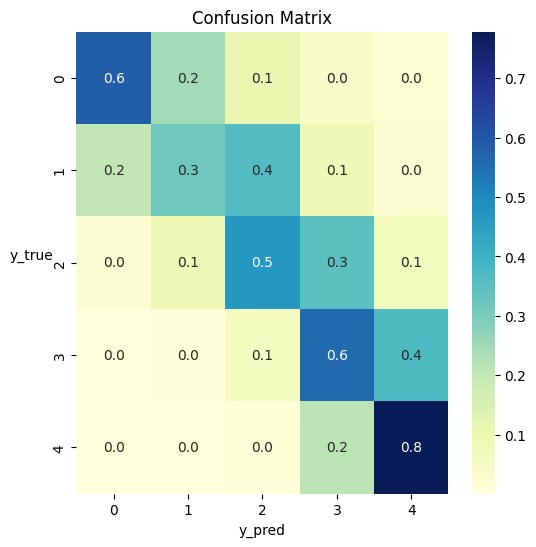

In [ ]:
draw_heatmap(matrics)